In [1]:
import re

import glob

import pandas as pd

import matplotlib

In [2]:
class TextFile:
    """
    Get information from a text file
    """

    def __init__(self, file):
        """
        Initialise a TextFile object.
        Parameters
        ----------
        file : str
            Path to the file
        """

        self.file = file

        with open(self.file, "r") as f:
            self.contents = f.read().splitlines()

    def get(self, pattern):
        """
        Search the contents of a file for a provided regex pattern and return a list of the
        specified groupings (one for each occurrence). Stolen and adapted from
        https://github.com/metomi/rose/blob/master/metomi/rose/apps/ana_builtin/grepper.py#L492
        Parameters
        ----------
        pattern: str
            The regex pattern
        """
        matched_groups = []
        for line in self.contents:
            search = re.search(pattern, line)
            if search:
                matched_groups.append(search.groups())
        return matched_groups
    
def parse_pbs_summary(file):
    """
    Parse relevant information from summary footer printed to the bottom of PBS
    output files on Gadi
    Parameters
    ----------
    file: str
        The file containing the PBS summary
    """

    def _duration(s):
        """
        Given duration in hrs:mins:secs, return mins
        """
        hms = s.split(":")
        return float(hms[0]) * 60 + float(hms[1]) + float(hms[2]) / 60

    to_parse = {
        "Service Units": float,
        "NCPUs Used": int,
        "CPU Time Used": _duration,
        "Walltime Used": _duration,
    }

    tf = TextFile(file)

    info = {}
    for p, f in to_parse.items():
        groups = tf.get(r"\s*{}:\s*([^ ]+)".format(p))
        if not groups:
            logger.warning(f"'{p}' not found in PBS output")
        if len(groups) > 1:
            logger.error(f"Multiple values found for '{p}' in PBS output")

        info[p] = f(groups[0][0])

    return info

In [3]:
info = []
for file in glob.glob("/g/data/tm70/ds0092/projects/nri_intake_catalog/scripts/build_all.sh.o*"):
    info.append(parse_pbs_summary(file))
    
df = pd.DataFrame(info).set_index("NCPUs Used").sort_index()
df["Speedup"] = df["Walltime Used"].loc[1] / df["Walltime Used"]

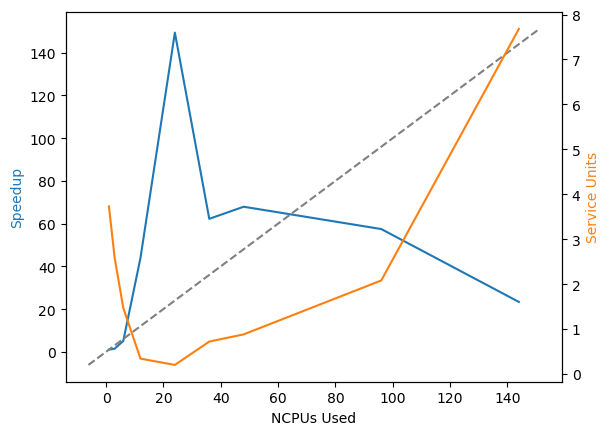

In [4]:
ax = df.plot(y="Speedup", legend=False, color="C0")
ax.plot(ax.get_xlim(),ax.get_xlim(), color="gray", linestyle="--")
ax.set_ylabel('Speedup', color="C0")

ax2 = ax.twinx()
df.plot(y="Service Units", ax=ax2, legend=False, color="C1")
_ = ax2.set_ylabel('Service Units', color="C1")

In [5]:
df

,Service Units,CPU Time Used,Walltime Used,Speedup
NCPUs Used,,,,
1,3.73,7.216667,12.450000,1.000000
3,2.58,9.350000,8.600000,1.447674
6,1.47,8.333333,2.450000,5.081633
12,0.34,0.100000,0.283333,43.941176
24,0.20,0.050000,0.083333,149.400000
36,0.72,0.100000,0.200000,62.250000
48,0.88,0.100000,0.183333,67.909091
96,2.08,0.100000,0.216667,57.461538
144,7.68,0.133333,0.533333,23.343750


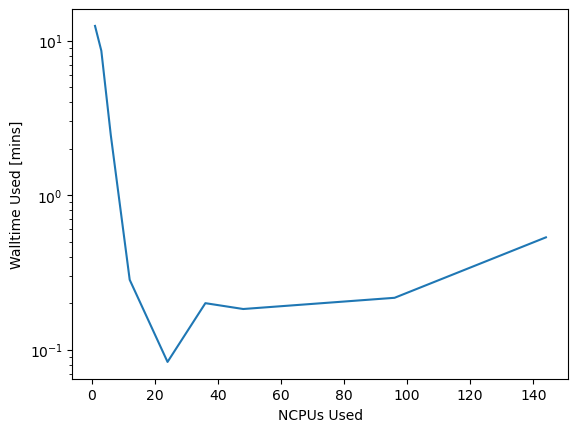

In [6]:
ax = df.plot(y="Walltime Used", legend=False)
ax.set_ylabel('Walltime Used [mins]')
ax.set_yscale("log")